<a href="https://colab.research.google.com/github/Rizwankaka/Agentic-AI-/blob/main/Langgraph/module-1/00_edges_nodes_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hello LangGraph

LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.

Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence.

LangGraph allows you to define flows that involve cycles, essential for most agentic architectures, differentiating it from DAG-based solutions.

As a very low-level framework, it provides fine-grained control over both the flow and state of your application, crucial for creating reliable agents.

Additionally, LangGraph includes built-in persistence, enabling advanced human-in-the-loop and memory features.

Key Features:
- **Cycles and Branching**: Implement loops and conditionals in your apps.
- **Persistence**: Automatically save state after each step in the graph. Pause and resume the graph execution at any point to support error recovery, human-in-the-loop workflows, time travel and more.
- **Human-in-the-Loop**: Interrupt graph execution to approve or edit next action planned by the agent.
- **Streaming Support**: Stream outputs as they are produced by each node (including token streaming).
- **Integration with LangChain**: LangGraph integrates seamlessly with LangChain and LangSmith (but does not require them).

https://langchain-ai.github.io/langgraph/

https://chatgpt.com/share/66f9d1bf-58e0-8002-84d0-1c1f8d5b4389

## The Simplest Graph
Let's build a simple graph with 2 nodes and simple edges flow.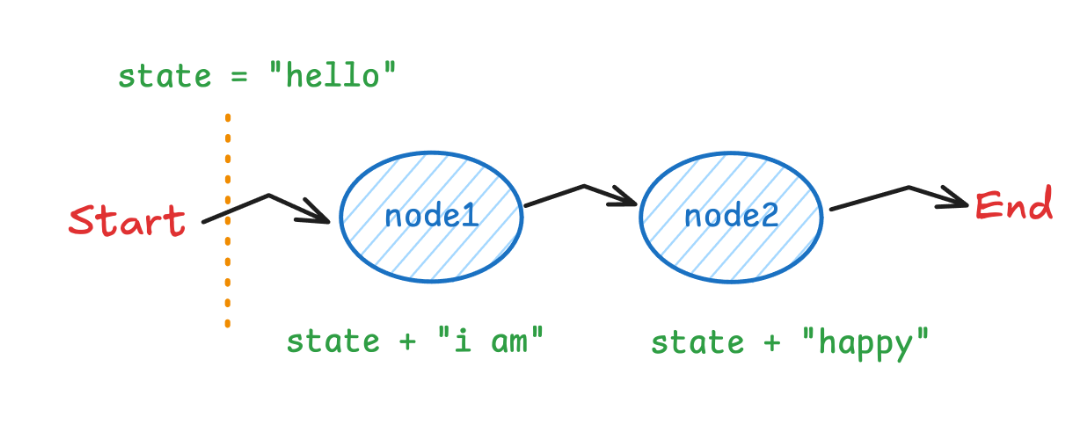

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## State

First, define the State of the graph.

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [2]:
from typing_extensions import TypedDict

class LearningState(TypedDict):
    prompt: str

In [3]:
# prompt: create an example from above LearningState
lahore_state: LearningState = LearningState(prompt= "hello from NED Karachi")

In [4]:
print(lahore_state)
print(lahore_state['prompt'])
print(lahore_state['prompt'] +" I am")
print(lahore_state)
print(type(lahore_state))

{'prompt': 'hello from NED Karachi'}
hello from NED Karachi
hello from NED Karachi I am
{'prompt': 'hello from NED Karachi'}
<class 'dict'>


## Nodes
[Nodes ](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes)are just python functions.

The first positional argument is the state, as defined above.

Because the state is a `TypedDict` with schema as defined above, each node can access the key, `graph_state`, with `state['graph_state']`.

Each node returns a new value of the state key `graph_state`.

By default, the new value returned by each node will [override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.

In [5]:
def node_1(state: LearningState) -> LearningState:
    print("---Node 1 State---", state)
    return {"prompt": state['prompt'] +" I am"}

def node_2(state: LearningState) -> LearningState:
    print("---Node 2 State---", state)
    return {"prompt": state['prompt'] +" happy!"}

## Edges
[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes.

Normal Edges are used if you want to always go from, for example, `node_1` to `node_2`.

## Graph Construction
Now, we build the graph from our components defined above.

The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.

First, we initialize a StateGraph with the `State` class we defined above.

Then, we add our nodes and edges.

We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.

The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node.

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure.

We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

In [6]:
from IPython.display import Image, display # Preview Graph

from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph # type

# Build graph
builder: StateGraph = StateGraph(state_schema=LearningState)

In [7]:
print(type(builder))

<class 'langgraph.graph.state.StateGraph'>


In [8]:
# Nodes
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

In [9]:
# Simples Edges Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

In [10]:
# Add
graph: CompiledStateGraph = builder.compile()

In [11]:
print(graph)

In [12]:
print(graph.get_graph())

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'node_1': Node(id='node_1', name='node_1', data=node_1(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), 'node_2': Node(id='node_2', name='node_2', data=node_2(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=<class 'langchain_core.utils.pydantic.LangGraphOutput'>, metadata=None)}, edges=[Edge(source='__start__', target='node_1', data=None, conditional=False), Edge(source='node_1', target='node_2', data=None, conditional=False), Edge(source='node_2', target='__end__', data=None, conditional=False)])


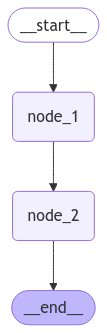

In [13]:
# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Graph Invocation

The compiled graph implements the runnable protocol.

This provides a standard way to execute LangChain components.

`invoke` is one of the standard methods in this interface.

The input is a dictionary `{"graph_state": "Hi, this is lance."}`, which sets the initial value for our graph state dict.

When `invoke` is called, the graph starts execution from the START node.

It progresses through the defined nodes (`node_1`, `node_2`, `node_3`) in order.

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the `END` node.

In [14]:
graph.invoke({"prompt" : "Hi"})

---Node 1 State--- {'prompt': 'Hi'}
---Node 2 State--- {'prompt': 'Hi I am'}


{'prompt': 'Hi I am happy!'}

invoke runs the entire graph synchronously.

This waits for each step to complete before moving to the next.

It returns the final state of the graph after all nodes have executed.

In this case, it returns the state after `node_3` has completed:

{'graph_state': 'Hi, this is Lance. I am sad!'}

## Task: In Nodes Use LLM == GoogleChatModel in Langchain

In [15]:
%pip install -q -U langchain
%pip install -q -U langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 2.4 MB/s eta 0:00:00


In [16]:
from google.colab import userdata
google_api_key = userdata.get('GEMINI_API_KEY')

In [17]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize an instance of the ChatGoogleGenerativeAI with specific parameters
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",  # Specify the model to use
    api_key=google_api_key,     # Provide the Google API key for authentication
)

In [18]:
# Import the AIMessage class currently will be used for typing
from langchain_core.messages.ai import AIMessage

ai_msg: AIMessage = llm.invoke("Hi?")

In [19]:
print(ai_msg.content)
print(type(ai_msg.content))

Hi there! How can I help you today?
<class 'str'>


In [20]:
from typing_extensions import TypedDict

class FirstLLMAgentCall(TypedDict):
    prompt: str
    output: str

In [21]:
def node_1(state: FirstLLMAgentCall):
    print("---Node 1---", state)
    prompt = state["prompt"]
    ai_msg: AIMessage = llm.invoke(prompt)
    return {"output": ai_msg.content}

In [23]:
rizwan_greet_message = node_1(FirstLLMAgentCall(prompt="Hello from Karachi"))
print(rizwan_greet_message)

---Node 1--- {'prompt': 'Hello from Karachi'}
{'output': "Hello from [location]!  It's great to connect with someone from Karachi."}


In [24]:
from IPython.display import Image, display # Preview Graph

from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph # type

# Build graph
builder: StateGraph = StateGraph(state_schema=FirstLLMAgentCall)

# Define Nodes
builder.add_node("node_1", node_1)

# Add Edges
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Compile Graph
graph: CompiledStateGraph = builder.compile()

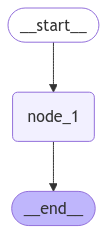

In [25]:
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
result = graph.invoke({"prompt" : "Motivate me to learn LangGraph"})

---Node 1--- {'prompt': 'Motivate me to learn LangGraph'}


In [27]:
print(result)

{'prompt': 'Motivate me to learn LangGraph', 'output': "Let's talk about why learning LangGraph could be a fantastic investment of your time and effort.  Forget the dry technicalities for a moment; let's focus on the *impact* and *opportunity*:\n\n**Imagine this:**\n\n* **You're at the forefront of a revolution:**  LangGraph sits at the intersection of two incredibly powerful and rapidly evolving fields: natural language processing (NLP) and graph databases.  Mastering it means being part of a small, highly sought-after group of professionals who can leverage this potent combination.\n\n* **Solving complex problems with elegance:**  Think about the messy, unstructured data that plagues so many industries.  LangGraph allows you to represent and reason over this data in a way that's both intuitive and powerful.  You can uncover hidden relationships, make accurate predictions, and build applications that were previously impossible.  Imagine building a system that automatically extracts in

In [28]:
# just another helpter function
import textwrap
from IPython.display import display, Markdown

def to_markdown(text)-> Markdown:
    text : str = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

In [29]:
print("PROMPT: ", result['prompt'])
to_markdown(result['output'])

PROMPT:  Motivate me to learn LangGraph


> Let's talk about why learning LangGraph could be a fantastic investment of your time and effort.  Forget the dry technicalities for a moment; let's focus on the *impact* and *opportunity*:
> 
> **Imagine this:**
> 
> * **You're at the forefront of a revolution:**  LangGraph sits at the intersection of two incredibly powerful and rapidly evolving fields: natural language processing (NLP) and graph databases.  Mastering it means being part of a small, highly sought-after group of professionals who can leverage this potent combination.
> 
> * **Solving complex problems with elegance:**  Think about the messy, unstructured data that plagues so many industries.  LangGraph allows you to represent and reason over this data in a way that's both intuitive and powerful.  You can uncover hidden relationships, make accurate predictions, and build applications that were previously impossible.  Imagine building a system that automatically extracts insights from legal documents, medical records, or scientific literature – that's the power of LangGraph.
> 
> * **Unlocking new career possibilities:**  The demand for skilled data scientists and NLP engineers is already high, and the specialized skills needed to work with LangGraph will only make you more valuable.  You'll be equipped to tackle challenging projects and command competitive salaries.
> 
> * **Contributing to meaningful innovations:**  LangGraph isn't just about technical prowess; it's about building tools that can solve real-world problems.  Imagine contributing to advancements in healthcare, finance, research, or even combating misinformation – LangGraph empowers you to make a tangible difference.
> 
> * **The learning curve is rewarding:**  While it might require effort, the journey of mastering LangGraph is deeply rewarding.  You'll be constantly learning, expanding your skillset, and pushing the boundaries of what's possible.  The sense of accomplishment from building something truly innovative is unparalleled.
> 
> **Instead of seeing LangGraph as a technical hurdle, see it as a key that unlocks a world of possibilities.**  It's an opportunity to be at the cutting edge, to solve challenging problems, and to build a rewarding career in a rapidly growing field.  So, take that first step.  Start exploring the resources available, and you'll quickly discover the incredible potential that awaits.  You've got this!